# TSP Fully Stateless Environment

- Stateful: the environment has a state
- Stateless: the environment does not have a state; state is passed as an argument to the step function

While stateless may be easier to manage, stateful can make up for more complex cases.

We want to implement a stateful environment so the dataloader needs to load less data.

> Note: this guide makes **all the utilities** to make a **stateless** environment. In other words, we generate all the parameters and put them in a batch. However, since for simplicity we suppose the parameters are the same for each batch, we do not need to do this thus saving some memory. This is done in the next notebook.

We follow [this guide](https://pytorch.org/rl/tutorials/pendulum.html) for implementing the environment in TorchRL and the following implementations:
- https://github.com/wouterkool/attention-learn-to-route/tree/master/problems/tsp
- https://github.com/yd-kwon/POMO/blob/master/NEW_py_ver/TSP/POMO/TSPEnv.py

Our scope is to integrate everything with the PyTorch Lightning framework: you may have a look this [notebook](https://github.com/fedebotu/lightning-torchrl/blob/main/1.pendulum-lightning-torchrl.ipynb) to get a rough idea ^^

We will try to make the environment `stateteless`, i.e. the environment will not store the state (we just pass everything in TensorDicts). This is supposed to have better properties than _stateful_ implementations, like the ones above.

In [1]:
%matplotlib inline

In [2]:
# Rich Traceback
from rich.traceback import install
install(show_locals=True)

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f2b04ad6670>>

In [3]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, UnboundedDiscreteTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

### Making the custom environment

Environment `_step`: this defines the state update of the TSP problem gived a TensorDict (`td` in the code) of the current state and the action to take:

In [4]:
def batch_to_scalar(param):
    """Return first element if in batch. Used for batched parameters that are the same for all elements in the batch."""
    if len(param.shape) > 0:
        return param[0].item()
    if isinstance(param, torch.Tensor):
        return param.item()
    return param


def _step(td: TensorDict) -> TensorDict:

    prev_a = td["action"] # NOTE was: [:, None]
    ids = td["ids"] if td["ids"][0] >= 0 else None # compatibility if no batch

    cur_coord = td["loc"][ids, prev_a] if ids is not None else td["loc"][prev_a]

    lengths = td["lengths"]
    if not td["cur_coord"].isnan().all():
        lengths += (cur_coord - td["cur_coord"]).norm(p=2, dim=-1)

    first_a = prev_a if batch_to_scalar(td["i"]) == 0 else td["first_a"]

    # Set visited to 1
    visited = td["visited"].scatter(-1, prev_a[...,None].expand_as(td["visited"]), 1)
      
    # We are done if all the locations have been visited
    done = (torch.count_nonzero(visited.squeeze(), dim=-1) >= td["params"]["n_loc"])
    
    # If we are not done, we set the cost to inf (reward is -inf)
    cost = torch.ones_like(done) * float("inf") 
       
    # If we are done, we set the reward to the length of the path, adding the distance to the first location
    if done.any():
        if ids is None:
            cost = lengths + td["dist"][first_a].norm(p=2, dim=-1)
        else:
            cost[done] = (lengths[done] + td["dist"][ids, first_a][done].norm(p=2, dim=-1)).squeeze(-1)
                
    # The output must be written in a ``"next"`` entry
    out = TensorDict(
        {
            "next": {
                "loc": td["loc"],
                "dist": td["dist"],
                "ids": td["ids"],
                "first_a": first_a,
                "prev_a": prev_a,
                "visited": visited,
                "lengths": lengths,
                "cur_coord": cur_coord,
                "i": td["i"] + 1,
                "params": td["params"],
                "reward": -cost,
                "done": done,
            }
        },
        td.shape,
    )
    return out

### Environment Reset
This defines the `_reset` of the TSP. It returns a TensorDict of the initial state:

In [5]:
def _reset(self, td: Optional[TensorDict] = None) -> TensorDict:
    # If no tensordict is passed, we generate a single set of hyperparameters
    # Otherwise, we assume that the input tensordict contains all the relevant parameters to get started.
    if td is None or td.is_empty():
        td = self.gen_params(batch_size=self.batch_size)
    batch_size = td.shape # batch size

    # Get unique parameters: we do not allow different params (e.g. sizes) on a single batch
    min_loc = batch_to_scalar(td["params", "min_loc"])
    max_loc = batch_to_scalar(td["params", "max_loc"])
    n_loc = batch_to_scalar(td["params", "n_loc"])
    
    # Generate locations. We could also load them directy from a dataset
    loc = (
        torch.rand((*batch_size, n_loc, 2), generator=self.rng)
        * (max_loc - min_loc)
        + min_loc
    )

    # Other variables
    dist = (loc[..., :, None, :] - loc[..., None, :, :]).norm(p=2, dim=-1)
    ids = torch.arange(sum([int(dim) for dim in batch_size]), dtype=torch.int64)[:, None] if len(batch_size) > 0 else -torch.ones(1, dtype=torch.int64) # special case for batch_size=()
    prev_a = torch.zeros((*batch_size, 1), dtype=torch.int64)
    visited = torch.zeros((*batch_size, 1, n_loc), dtype=torch.uint8)
    lengths=torch.zeros((*batch_size, 1))
    cur_coord = torch.ones((*batch_size, 1, 2), dtype=torch.float32) * float("nan") # first coord is nan
    i = torch.zeros((*batch_size, 1), dtype=torch.int64) # Vector with length num_steps
   
    # Output is a tensordict
    out = TensorDict(
        {
            "loc": loc,
            "dist": dist,
            "ids": ids,
            "first_a": prev_a,
            "prev_a": prev_a,
            "visited": visited,
            "lengths": lengths,
            "cur_coord": cur_coord,
            "i": i,
            "params": td["params"],
        },
        batch_size=batch_size,
    )
    return out


### Environment metadata 

This defines the input and output domains of the environment - similar to Gym's `spaces`:

In [6]:
def _make_spec(self, td_params):
    params = td_params["params"]
    n_loc = params["n_loc"] # TSP size
    self.observation_spec = CompositeSpec(
        loc=BoundedTensorSpec(
            minimum=params["min_loc"],
            maximum=params["max_loc"],
            shape=(n_loc, 2),
            dtype=torch.float32,
        ),
        dist=UnboundedContinuousTensorSpec(
            shape=(n_loc, n_loc),
            dtype=torch.float32,
        ),
        ids=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        first_a=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        prev_a=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        visited=UnboundedDiscreteTensorSpec(
            shape=(1, n_loc),
            dtype=torch.uint8,
        ),
        lengths=UnboundedContinuousTensorSpec(
            shape=(1),
            dtype=torch.float32,
        ),
        cur_coord=UnboundedContinuousTensorSpec(
            shape=(1, 2),
            dtype=torch.float32,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        # we need to add the "params" to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(params),
        shape=(),
    )
    # since the environment is stateless, we expect the previous output as input
    self.input_spec = self.observation_spec.clone()
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        minimum=0,
        maximum=n_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom funtion to convert a tensordict in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

### Seeding for reproducible experiments

In [7]:
def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

### Parameter generation

This function deterministically generates the parameters for the environment:

In [8]:
def gen_params(self, batch_size=None) -> TensorDictBase:
    """Returns a tensordict containing the parameters of the environment."""
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "min_loc": 0,
                    "max_loc": 1,
                    "n_loc": self.n_loc,
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

### Environment creation

Here we use `EnvBase` to create the environment similarly to gym:

In [9]:
class TSPEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, n_loc=10, td_params=None, seed=None, device="cpu"):
        self.n_loc = n_loc
        if td_params is None:
            td_params = self.gen_params()
        
        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = gen_params # originally static method
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    # _step = _step # theoretically staticmethod, but we need to access self
    _step = staticmethod(_step)
    _set_seed = _set_seed


### Testing the environment

In [10]:
env = TSPEnv(n_loc=5)
check_env_specs(env)

check_env_specs succeeded!


In [11]:
td = env.reset()
for i in range(3):
    td.set("action", torch.tensor([i]))
    print(td['action'])
    td = env.step(td)['next']
    print("visited2", td['visited'])
    td.set("action", torch.tensor([i]))
    td = env.step(td)['next']

tensor([0])
visited2 tensor([[1, 0, 0, 0, 0]], dtype=torch.uint8)
tensor([1])
visited2 tensor([[1, 1, 0, 0, 0]], dtype=torch.uint8)
tensor([2])
visited2 tensor([[1, 1, 1, 0, 0]], dtype=torch.uint8)


### Plotting

In [20]:
visited = rollout['visited'][:, -1]

torch.count_nonzero(visited.squeeze(), dim=-1)

tensor([3, 3, 3, 3, 3, 2, 3, 3, 4, 4, 4, 3, 2, 2, 3, 3, 2, 2, 3, 3, 4, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 4, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        4, 3, 2, 3, 3, 4, 3, 4, 3, 4, 3, 3, 2, 2, 4, 3, 3, 3, 3, 2, 3, 2, 2, 3,
        2, 4, 2, 3, 3, 3, 4, 4, 4, 3, 2, 2, 3, 3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 4, 3, 4])

In [12]:
rollout = env.rollout(
    50,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(env.gen_params(batch_size=[128])),
    break_when_any_done=True
)

In [15]:
import matplotlib.pyplot as plt

def plot_tsp_solution(td):
    td = td.detach().cpu()
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]


    # Get the coordinates of the visited nodes for the first batch element
    visited_coords = td['loc'][td['visited'][0, 0] == 1][0]

    # Create a plot of the nodes
    fig, ax = plt.subplots()
    ax.scatter(td['loc'][:, 0], td['loc'][:, 1], color='blue')

    # Plot the visited nodes
    ax.scatter(visited_coords[:, 0], visited_coords[:, 1], color='red')

    # Add arrows between visited nodes as a quiver plot
    x = visited_coords[:, 0]
    y = visited_coords[:, 1]
    dx = np.diff(x)
    dy = np.diff(y)

    # Colors via a colormap
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(vmin=0, vmax=len(x))
    colors = cmap(norm(range(len(x))))

    ax.quiver(x[:-1], y[:-1], dx, dy, scale_units='xy', angles='xy', scale=1, color=colors)

    # Add final arrow from last node to first node
    ax.quiver(x[-1], y[-1], x[0]-x[-1], y[0]-y[-1], scale_units='xy', angles='xy', scale=1, color="red", linestyle="dashed")

    # Plot numbers inside circles next to visited nodes
    for i, coord in enumerate(visited_coords):
        ax.add_artist(plt.Circle(coord, radius=0.02, color=colors[i]))
        ax.annotate(str(i+1), xy=coord, fontsize=10, color='white',
                    va="center", ha="center")

    # Set plot title and axis labels
    ax.set_title('TSP Solution\nTotal length: {:.2f}'.format(-td['reward'][0]))
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    ax.set_aspect('equal')

    plt.show()


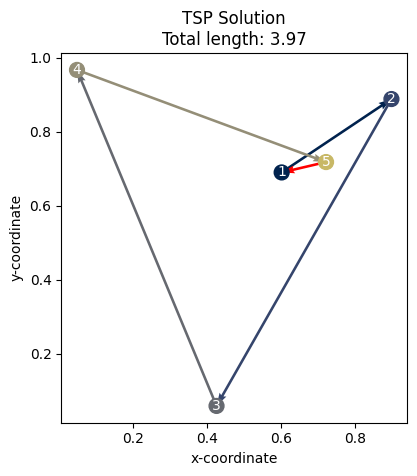

In [16]:
# get greater than -inf reward indexes
last_state = rollout['next'][:, -1]
idx = last_state["reward"] > -float('inf')
rollout_finished = last_state[idx.squeeze()]

plot_tsp_solution(rollout_finished)